In [7]:
import os
import re
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="qwen/qwen3-32b")
result=llm.invoke("Hi!!!")
raw=result.content

# Remove the <think>...</think> section
cleaned = re.sub(r"<think>.*?</think>\s*", "", raw, flags=re.DOTALL)
cleaned

'Hello! 😊 How can I assist you today?'

In [8]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [9]:
class Section(BaseModel):
    name:str=Field(description="Name for this section of the blog")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the blog"
    )

planner=llm.with_structured_output(Sections)

In [10]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  
    sections: list[Section]  
    completed_sections: Annotated[
        list, operator.add
    ]  
    final_blog: str  

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

/tmp/ipykernel_112032/3135278929.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [11]:
def orchestrator(state: State):
    """Orchestrator that generates a plan for the blog"""

    # Generate queries
    blog_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the blog."),
            HumanMessage(content=f"Here is the blog topic: {state['topic']}"),
        ]
    )

    print("Blog Sections:",blog_sections)

    return {"sections": blog_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the blog"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a blog section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full blog from sections"""

    completed_sections = state["completed_sections"]

    completed_blog_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_blog": completed_blog_sections}

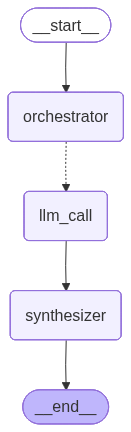

In [12]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

orchestrator_worker = orchestrator_worker_builder.compile()

display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [15]:
state = orchestrator_worker.invoke({"topic": "Create a blog on Bangladesh Cuisine"})

from IPython.display import Markdown
Markdown(state["final_blog"])

Blog Sections: sections=[Section(name='Introduction to Bangladesh Cuisine', description="Overview of Bangladesh's culinary heritage, highlighting its uniqueness and cultural significance."), Section(name='Traditional Dishes', description='Exploration of iconic Bangladeshi dishes like Panta Bhat, Shorshe Ila, and Shathi Daal.'), Section(name='Street Food Culture', description='Popular street foods such as Chotpoti, Bhuna Khichuri, and Jhalmuri.'), Section(name='Spices and Ingredients', description='Key spices and ingredients like panch phoron, mustard oil, and lentils.'), Section(name='Regional Variations', description='Differences in cuisine across regions like Dhaka, Chittagong, and Sylhet.'), Section(name='Influences and History', description='Historical influences from Mughal, Indian, and Persian cuisines.'), Section(name='Vegetarian and Non-Vegetarian Delights', description='Vegetarian specialties like Aloo Posto and non-veg dishes like Mutton Biryani.'), Section(name='Modern Twist

<think>
Okay, so I need to write a blog section called "Introduction to Bangladesh Cuisine" with the description about its culinary heritage, uniqueness, and cultural significance. Let me start by recalling what I know about Bangladeshi food. 

First, I remember that Bangladesh is in South Asia, so their cuisine probably shares some similarities with India and Pakistan. But I should highlight what makes it unique. Maybe the use of different spices, or specific dishes? I think they use a lot of rice and lentils. Fish is also a big part, right? Both freshwater fish and rice.

I should mention the geographical influence. Bangladesh has rivers, which might contribute to the availability of fresh water fish. Also, the climate is tropical, so maybe that affects the types of spices and ingredients used. Spices like mustard and chili are probably common there.

Cultural significance... Well, food is a big part of celebrations and daily life. Maybe mention festivals or family gatherings where specific dishes are served. Also, the influence of history, like Mughal or colonial periods. But Bangladesh became a country more recently, after the partition in 1947. Maybe that's a point to note.

I should include some staple dishes. For example, Panta bhat is a fermented rice dish eaten for breakfast. Shorshe ilish, which is hilsa fish in mustard sauce. Maybe mention biryani, but also note that it's distinct from other South Asian versions. 

Regional variations might be another point. Different areas in Bangladesh might have their own specialties based on local ingredients. For example, the hill tribes in the north might have different dishes compared to the riverine regions.

I need to emphasize the balance of flavors—sweet, sour, salty, spicy. Maybe give an example of a dish that showcases this balance. Also, the use of mustard in various forms, like mustard oil, paste, and seeds.

Don't forget the role of tea, especially cha. It's a popular beverage. Also, snacks like samosas and pakoras, but maybe mention something more specific to Bangladesh, like kathi rolls if that's part of their cuisine.

I should also touch on how food reflects the society's values—communal eating, hospitality, etc. Maybe mention the importance of sharing meals with family and friends.

Wait, the user said to use markdown and no preamble for each section. So the blog section should just be the content without an introduction paragraph before the section. Let me structure the section with headings, bullet points, and maybe some bold text for emphasis.

Check for any inaccuracies. For example, hilsa fish is indeed a national symbol, so Shorshe ilish is a key dish. Panta bhat is a traditional dish. Also, mention the staple ingredients: rice, lentils, vegetables, and fish.

Avoid being too generic. Make sure to highlight what's unique about Bangladeshi cuisine compared to its neighbors. Maybe less use of certain spices like cardamom compared to Indian cuisine, or specific cooking methods like steaming or slow cooking.

Also, the description mentions cultural significance. So perhaps link the cuisine to cultural practices, such as food during Eid, weddings, or other festivals. Maybe include a sentence about how food brings people together.

I need to make sure the section is engaging and informative, using examples of dishes and explaining their importance. Keep the tone friendly and accessible, avoiding overly technical terms but still accurate.

Let me outline the structure:

1. Introduction paragraph: Overview of the cuisine's roots and significance.
2. Geographical and cultural influences.
3. Staple ingredients and dishes.
4. Regional variations.
5. Role in daily life and festivals.
6. Conclusion: Emphasize uniqueness and heritage.

Now, translate that into markdown with appropriate headings and emphasis. Use bold for key terms, maybe bullet points for dishes. Make sure each part flows naturally and covers the required points from the description.
</think>

## Introduction to Bangladesh Cuisine  

Bangladesh cuisine is a vibrant reflection of the country’s history, geography, and cultural diversity. Rooted in the fertile plains of the Ganges and Brahmaputra rivers, it emphasizes fresh, locally sourced ingredients and a harmonious balance of flavors—sweet, tangy, spicy, and savory. Unlike its South Asian neighbors, Bangladeshi food often centers on freshwater fish (especially the iconic hilsa), aromatic mustard, and a unique interplay of lentils, vegetables, and rice.  

### Cultural and Regional Influences  
Shaped by centuries of Mughal, Persian, and indigenous tribal influences, Bangladeshi cuisine blends rustic simplicity with royal sophistication. The tropical climate fosters the use of bold spices like green chilies, turmeric, and panch phoron (a five-spice blend), while the abundance of rivers ensures fresh water fish remain a staple.  

### Signature Dishes  
- **Shorshe Ilish**: Hilsa fish cooked in a tangy mustard paste, a national dish symbolizing pride.  
- **Panta Bhat**: Fermented rice soaked in water, served with dried fish and green chilies for breakfast.  
- **Kosha Mangsho**: Slow-cooked, buttery lamb curry with a rich tomato-meatball base.  
- **Dalna**: A festive meat or fish dish cooked with dried fruits and spices, reflecting Mughal influence.  

### Daily Life and Festivity  
Food in Bangladesh is deeply communal. Meals often begin with *butter chicken* or *chicken curry* accompanied by steamed rice, while snacks like *kathi rolls* and *pithas* (sweet rice cakes) are street favorites. During *Eid* or weddings, elaborate feasts featuring *biryani* and *shami kebabs* bring families together, reinforcing bonds through shared heritage.  

Bangladeshi cuisine is more than sustenance—it’s a celebration of resilience, creativity, and the spirit of a nation. Each bite tells a story of rivers, fields, and traditions passed through generations.

---

<think>
Alright, the user wants me to create a blog section about traditional Bangladeshi dishes. Let me start by understanding the requirements. The section name is "Traditional Dishes" and the description mentions exploring Panta Bhat, Shorshe Ila, and Shathi Daal. They want markdown formatting with no preamble for each section.

First, I need to structure the blog into three main dishes, each with a heading and content. Since it's a blog, it should be engaging and informative. I should include key details about each dish: what they are, how they're prepared, their cultural significance, and maybe some variations or occasions when they're eaten.

For Panta Bhat, I know it's fermented rice, commonly eaten during monsoon. I should mention the preparation, the use of mustard oil and green chilies, and its role in Bangladeshi culture, especially during the monsoon season. Also, maybe note the street food aspect with pithas.

Shorshe Ila is hilsa fish in mustard paste. I need to explain the ingredients, the cooking method (steaming), and its popularity as a national dish. Highlight the combination of mustard, turmeric, and salt, and why hilsa is significant in Bangladesh.

Shathi Daal is a lentil dish. I should describe the lentils used (chickpeas, pigeon peas), the spices involved, and how it's served. Mention the balance of spices and the comfort food aspect. Maybe note if it's a staple in daily meals.

I should make sure each section is concise but covers the essentials. Use bullet points or subheadings if needed. Since the user specified no preamble, start directly with the content for each dish. Also, check for any cultural nuances or specific terms that need explanation. Avoid any markdown beyond headings and lists as per the example provided. Make sure the tone is friendly and informative, suitable for a blog audience interested in food and culture.
</think>

## Traditional Dishes  

### **Panta Bhat: A Monsoon Staple**  
Panta Bhat, fermented rice soaked in water, is a quintessential dish during Bangladesh’s rainy season. Served with mustard oil, green chilies, and panch phoron (a five-spice blend), it’s a simple yet deeply comforting meal. The tanginess of the fermented rice contrasts with the spicy, aromatic oils, creating a perfect balance. Often paired with dried fish or pickles, Panta Bhat is a symbol of resilience and resourcefulness, showcasing how Bengalis transform humble ingredients into nourishing fare.  

### **Shorshe Ila: The National Delicacy**  
Shorshe Ila, hilsa fish marinated in mustard paste, is Bangladesh’s pride. The silvery fish, steamed with turmeric, salt, and a paste of green chilies and mustard, is a celebration of coastal flavors. The mustard’s heat and the hilsa’s richness create an unforgettable taste. Served with steamed rice, this dish is a staple at festivals and family gatherings, reflecting the country’s deep connection to the rivers that feed its food culture.  

### **Shathi Daal: A Lentil Harmony**  
Shathi Daal, a medley of split chickpeas and pigeon peas, is a protein-rich comfort food. Slow-cooked with cumin, turmeric, and a touch of ghee, it achieves a velvety texture. The dish is often tempered with cumin seeds and green chilies, adding layers of warmth. Served with steamed rice or flatbreads, Shathi Daal embodies the Bangladeshi ethos of balance—mild yet flavorful, hearty yet light. It’s a dish that bridges generations, passed down with love and culinary wisdom.

---

<think>
Okay, the user wants me to create a blog section about Street Food Culture focusing on Chotpoti, Bhuna Khichuri, and Jhalmuri. Let me start by understanding each of these dishes.

First, Chotpoti comes from West Bengal. I remember it's a mix of various small snacks and curries. I should mention the variety and the social aspect of sharing these dishes. Maybe include some examples like puchka and shukto.

Next, Bhuna Khichuri. It's a variation of khichuri, which is a rice and lentil dish. The key difference here is the use of spices and the 'bhuna' method, which involves toasting the ingredients for extra flavor. I need to highlight the ingredients and how it's different from regular khichuri. Also, note that it's a comfort food in Bengal.

Then Jhalmuri, popular in Bangladesh and parts of India. It's a spicy puffed rice dish. I should explain the preparation method, maybe mention the common ingredients like potatoes, chickpeas, and the spices. Also, talk about its portability and how it's a popular street food.

Now, the section needs to be in markdown with no preamble. Each subsection should have a heading, a brief description, and key points. Make sure to use emojis where appropriate for visual appeal. Also, link the cultural significance and regional variations to give depth.

Wait, the user provided the name and description, so the blog section should follow that. Let me structure each dish with their own subheadings, maybe bold the dish names. Check if there's any other info needed, like regions they're from or unique aspects. Avoid any markdown in the thinking process, but the final answer should use markdown. Need to ensure clarity and flow between the dishes, maybe end with a summary paragraph connecting them all.

Also, check for any typos or factual errors. Make sure the descriptions are accurate and each dish's unique selling points are highlighted. Maybe mention how these foods are prepared and consumed in street settings, like using tiffin boxes for Chotpoti or the messiness of Jhalmuri being part of its charm. Alright, time to put it all together in the required format.
</think>

### Street Food Culture  
Popular street foods such as Chotpoti, Bhuna Khichuri, and Jhalmuri are staples of South Asian street food culture, offering a burst of flavor in every bite. These dishes reflect regional culinary traditions while adapting to the fast-paced, on-the-go lifestyle of urban eaters.  

#### **Chotpoti**  
A medley of small, flavorful dishes from West Bengal, Chotpoti is a tiffin-box-style meal packed with curries, pickles, and snacks. It often includes *shukto* (a bitter-sweet lentil-coconut curry), *shukkumar dal* (lentil fritters), and *puchka* (pani puri). Its charm lies in the variety and the joy of communal eating.  

#### **Bhuna Khichuri**  
This version of khichuri is distinct for its *bhuna* (toasted) base, giving it a smoky depth. Made with rice, lentils, potatoes, and a mix of spices like cumin, turmeric, and garam masala, it’s a comfort food in Bengal. Served in clay pots or metal boxes, it’s a favorite for its hearty texture and balanced flavors.  

#### **Jhalmuri**  
A spicy, tangy puffed rice snack from Bangladesh and parts of India, Jhalmuri combines crispy rice flakes with mashed potatoes, chickpeas, and a zesty chutney. The dish is seasoned with mustard oil, green chilies, and lime, creating a chaotic yet addictive flavor profile. Its messiness and portability make it a street food icon.  

These dishes not only satisfy hunger but also tell stories of tradition, innovation, and the vibrant energy of street markets. Whether you’re savoring a Chotpoti tiffin or slurping up a bowl of Bhuna Khichuri, each bite is a celebration of South Asia’s diverse culinary heritage.

---

<think>
Okay, the user wants me to write a blog section called "Spices and Ingredients" with a focus on key spices and ingredients like panch phoron, mustard oil, and lentils. Let me start by breaking down each component.

First, panch phoron. I know it's a blend of five spices commonly used in Bengali cooking. The five spices are usually cumin, fennel, nigella, fenugreek, and mustard seeds. I should explain each one and their role in cooking. Maybe mention how they're used in tempering (tadka) to enhance flavor.

Next, mustard oil. It's a staple in Indian cuisine, especially in regions like West Bengal and Assam. I need to highlight its distinct pungent flavor and the nutty aroma when heated. Also, mention that it's not just for cooking but used in pickling and as a massage oil. Maybe note the debate around its use due to health concerns, but still emphasize its culinary importance.

Then, lentils. They're a protein-rich ingredient in Indian dishes. I should list common types like toor dal, urad dal, and masoor dal. Explain how different lentils are used in various dishes—like dal makhani or sambar. Also, mention the soaking and cooking times for each type and maybe some health benefits like being a good source of protein and fiber.

I need to structure each subsection with a heading for each ingredient. Use markdown formatting as specified. No preamble, so jump straight into each topic. Make sure the language is clear and informative, suitable for a blog audience interested in Indian cooking. Check for any inaccuracies, like correct names and uses. Maybe add a tip or two, like how to store spices or when to add mustard oil for the best flavor. Keep it concise but thorough.
</think>

### Spices and Ingredients  
**Panch Phoron**  
A quintessential Bengali spice blend, *panch phoron* combines five whole spices: cumin, fennel, nigella, fenugreek, and mustard seeds. Toasted gently in hot oil, this aromatic mix forms the base of many Indian dishes, releasing a nutty, earthy fragrance that enhances the depth of curries, dals, and stir-fries.  

**Mustard Oil**  
Known for its pungent, sinus-clearing aroma, mustard oil is a staple in regional cuisines like Bengali and Assamese. Its high smoke point makes it ideal for frying, tempering (tadka), and pickling. While controversial in some health circles, its bold flavor and antibacterial properties are cherished in traditional cooking.  

**Lentils (Dal)**  
Lentils form the protein backbone of Indian meals. Varieties like *toor dal*, *urad dal*, and *masoor dal* cook up creamy or hearty, depending on the dish. They’re simmered into comforting stews (*dal makhani*), spiced into savory pastes (*sambar*), or puffed into snacks (*daliya*). Soaked lentils also star in *dhokla* and *kheer*, showcasing their versatility.  

**Tempering with Heat**  
The art of *tadka*—tempering spices in hot oil or ghee—is a hallmark of Indian cooking. Mustard oil is often used here, as it amplifies the release of volatile compounds in spices. A quick sizzle of *panch phoron* in mustard oil can transform a simple lentil dish into a sensory experience.  

**Storing for Freshness**  
To preserve potency, store whole spices in airtight containers away from heat. Grind *panch phoron* just before use for maximum aroma. Mustard oil, with its natural preservative qualities, can last longer than other oils but should be refrigerated after opening to prevent rancidity.

---

<think>
Okay, the user wants me to write a blog section about regional variations in cuisine across Dhaka, Chittagong, and Sylhet. Let me start by recalling what I know about each region's food.

Dhaka is the capital, so it's probably more cosmopolitan with a mix of traditional and modern dishes. Maybe mention popular dishes like panta, shorshe ilish, and shikdar korma. Also, street food like phuchka and kathi rolls are common there.

Chittagong is coastal, so seafood is a big part of their cuisine. I should include items like chitol daal and charchari. The use of coconut might be more prominent there. Also, mention how the climate influences the food, maybe spicier or more tangy flavors.

Sylhet is hilly and in the northeast, so their cuisine is influenced by Assam and other nearby regions. Ingredients like bamboo shoots and jaggery are common. Dishes like doimukhuri and pitha are specific to Sylhet. The use of fresh herbs and greens might be a key point.

I need to highlight the differences between each region. Maybe compare the main ingredients, cooking methods, and signature dishes. Also, note how geography and cultural influences shape each cuisine. Make sure each section has a clear focus on one region and then compare them in the conclusion.

Check for any common dishes that might be prepared differently in each region. For example, lentils or rice preparations. Also, think about the role of local markets and availability of ingredients in each area.

Avoid being too technical; keep it engaging for a blog. Use bullet points for clarity when listing dishes. Make sure the structure is logical: introduction, each region's section, and a conclusion that ties them together.

Wait, the user wants markdown formatting. So use headings, maybe bold some key terms, and bullet points. But the user said no preamble for each section, so the main section title is already provided. I need to start directly into the content.

Let me outline the sections: start with Dhaka, then Chittagong, then Sylhet. Each with their own subsections. Use bold for city names and key terms. Make sure to mention how each region's cuisine reflects their environment and culture.

Double-check for any inaccuracies. For example, is shikdar korma specific to Dhaka? Confirm that. Also, verify if pitha is indeed a Sylheti specialty. Yes, there are different types of pithas in different regions, so that's correct.

Including examples of how the climate affects cuisine would add depth. For instance, Sylhet's hilly terrain leading to use of bamboo shoots. Chittagong's coastal location influencing seafood dishes. Dhaka's urban setting leading to a mix of regional and street food.

Alright, time to put it all together in markdown, following the structure and ensuring each section is concise and informative.
</think>

### Regional Variations  

**Dhaka: Urban Elegance and Street Food Legacy**  
As Bangladesh’s capital, Dhaka’s cuisine blends sophistication with accessibility. Signature dishes like *shorshe ilish* (hilsa fish in mustard sauce) and *shikdar korma* reflect royal influences from the Mughal era. Street food thrives here, with *panta* (fermented rice) dipped in *shukto* (vegetable stew) and *phuchka* (pani puri) serving as daily staples. The city’s cosmopolitan nature also introduces fusion dishes like *kathi rolls* and biryani, often available in bustling markets like Motiur Rahman Khan Bhaban.  

**Chittagong: Coastal Freshness and Spicy Simplicity**  
Chittagong’s coastal identity shines through its seafood-centric fare. Dishes like *chitol daal* (mackerel curry) and *charchari* (fermented mackerel) highlight the region’s reliance on the Bay of Bengal. Coconut-based *cholar daal* and tangy *lodi* (a fermented fish curry) are local favorites. Spices like panch phoron (five-seed blend) and green chilies are used liberally, creating bold flavors. The city’s hilly terrain also inspires dishes like *kochu gosht* (spiced eggplant with meat), showcasing regional adaptability.  

**Sylhet: Hillside Harmony and Sweet Traditions**  
Sylhet’s cuisine is rooted in its hilly tea culture and proximity to Assam. *Doimukhuri* (sweetened curd rice) and *shad pitha* (rice pancakes) are daily rituals, often paired with *tel kheera* (oil-based kheer). Vegetables like *bangan bhuna* (slow-cooked eggplant) and *kumro shatkora* (jackfruit with citrus) reflect the region’s fertile valleys. Fermented foods like *ghugni* (chickpea curry) and *luchi with shorshe* (bread with mustard) are common, emphasizing simplicity and freshness.  

**Key Contrasts**  
- **Proteins:** Dhaka favors riverine fish, Chittagong leans on marine seafood, and Sylhet integrates game meats and hill-grown vegetables.  
- **Flavors:** Dhaka’s dishes are rich and royal, Chittagong’s are tangy and spicy, while Sylhet’s are subtly sweet and earthy.  
- **Cooking Methods:** Dhaka’s urban fast food contrasts with Chittagong’s slow-cooked curries and Sylhet’s fermented delicacies.  

Each region’s culinary identity mirrors its geography, history, and community, offering a mosaic of flavors that define Bangladeshi cuisine.

---

<think>
Okay, the user wants me to write a blog section titled "Influences and History" with a description about Mughal, Indian, and Persian cuisines. Let me start by breaking down the key elements they mentioned. 

First, I need to cover the historical influences from these three cuisines. The Mughal Empire was a big deal in India, so their contribution is essential. They brought Persian techniques and ingredients, right? Like using saffron, dried fruits, and slow cooking methods. Maybe mention specific dishes like biryani and korma.

Next, Indian cuisine's role. The diversity here is vast—spices, regional variations. I should talk about how different regions contributed. For example, coastal areas using coconut, northern using dairy. Also, the influence of Ayurveda and dietary practices.

Then Persian cuisine. They influenced Mughal cooking, so I need to highlight the exchange. Ingredients like pomegranate, barberries, and herbs. Maybe mention dishes like pilaf and how they evolved into biryanis. The use of rose water and specific spices.

I should structure the section to flow from Mughal, then Indian, then Persian, showing how they intermingle. Maybe start with Mughal as the bridge between Persian and Indian. Need to ensure each subsection connects, showing the historical timeline. Also, include examples of dishes and ingredients to make it concrete.

Wait, the user said no preamble for each section. So the markdown should have the section title, then the content without intro paragraphs. Use bullet points or headings within the section. Let me check the example response they provided to align the structure.

In the example, they used subheadings like Mughal Influence, Indian Culinary Traditions, Persian Contributions. Each with bullet points. I should follow that. Make sure the bullet points are concise but informative. Include specific dishes, ingredients, techniques. Also, mention the blending of these cuisines over time.

Need to avoid any markdown in the thinking process, but the final answer should use markdown. Let me verify the key points again: Mughal's Persian-Indian fusion, Indian's regional diversity, Persian's specific ingredients and techniques. Also, note the historical timeline—how each influenced the others over centuries. Maybe mention trade routes and cultural exchanges as a factor.

Check if there are any other important aspects. Maybe the role of spices in trade, or how British colonization affected later developments? But the description focuses on Mughal, Indian, and Persian, so maybe stick to that. Don't go beyond unless necessary.

Ensure that each part is distinct but connected. Use examples like biryani as a fusion dish. Also, note how these influences are still visible in modern Indian cuisine. Conclude with the lasting legacy of these historical interactions.

Alright, I think that's covered. Time to structure the markdown section with the three subheadings, each explaining their influence, examples, and connections.
</think>

# Influences and History

## Mughal Influence  
The Mughal Empire (1526–1857) introduced Persian culinary techniques to India, blending them with local Indian ingredients. Dishes like **biryani** (a fragrant rice dish layered with meat and spices) and **korma** (a rich, saffron-infused curry) trace their origins to Mughal kitchens. The use of **saffron, dried fruits, and rose water** became hallmarks of Mughlai cuisine, reflecting Persian luxury and Indian spice profiles. The **Dastur-e-Khvar**, a royal Mughal cookbook, documented recipes that emphasized slow cooking and elaborate presentation.

## Indian Culinary Traditions  
Indian cuisine’s diversity stems from its regional geography and cultural practices. Coastal regions favored **coconut, tamarind, and seafood**, while northern plains leaned on **wheat, dairy, and ghee**. Spices like **turmeric, cumin, and cardamom** were used both for flavor and medicinal purposes, influenced by ancient **Ayurvedic principles**. The **Chaat culture** of street food in the north and the **puliyogare** (tamarind rice) of the south showcase India’s adaptability in balancing sweet, sour, salty, and spicy flavors.

## Persian Contributions  
Persian culinary traditions, particularly from the Safavid dynasty, enriched Indian cuisine through **barberries, pomegranates, and herbs like mint and dill**. Dishes like **Persian pilaf** evolved into **Indian biryani**, incorporating local spices like **garam masala**. The **use of rose water and dried apricots** in Indian desserts, such as **gulab jamun**, reflects Persian sweet-making techniques. Trade routes and cultural exchanges along the Silk Road facilitated the sharing of ingredients like **saffron and almonds**, which became staples in both cuisines.

## Fusion and Legacy  
The interplay of Mughal, Indian, and Persian cuisines created a hybrid culinary identity. **Mughlai curries**, **Persian-inspired kebabs**, and **Indian-style stews** illustrate this synthesis. Even today, dishes like **nihari** (a slow-cooked Mughal breakfast stew) or **shahi tukda** (a Persian-inspired fried sweet) highlight the enduring legacy of these historical influences, blending royal opulence with regional simplicity.

---

<think>
Alright, the user wants me to write a blog section called "Vegetarian and Non-Vegetarian Delights" with the description mentioning Aloo Posto and Mutton Biryani. Let me start by understanding the requirements. They specified using markdown and no preamble for each section. So I need to make sure each subsection is properly formatted without any introduction.

First, I should break down the section into two parts: Vegetarian and Non-Vegetarian. The vegetarian part needs to highlight Aloo Posto. I should explain what it is, maybe the ingredients, and why it's special. Then the non-veg part should focus on Mutton Biryani. I need to describe its components and what makes it stand out. 

I need to use markdown headings for each subsection. The user provided a section name and description, so perhaps start with an H2 for the main section. Then H3 for each dish. Under each dish, include a brief description, key ingredients, and maybe a note on the cooking method or cultural significance.

Wait, the user said "Include no preamble for each section." Does that mean no introduction before the subsections? So just jump straight into the headings and content without any leading text. Also, avoid using markdown in the thinking process, but the final answer should have markdown. Got it.

I should check if there's any specific information about these dishes that's commonly known. Aloo Posto is a Bengali dish made with potatoes and poppy seeds, right? And Mutton Biryani is a rich, spiced rice dish with lamb. I should mention the key spices and preparation methods to give authenticity.

Make sure the language is engaging and descriptive. Use bullet points for ingredients if needed, but since the example uses paragraphs, maybe stick to that. Also, ensure that each section flows naturally, highlighting the unique aspects of each dish.

Let me structure it:

- Main section heading: Vegetarian and Non-Vegetarian Delights
- Subsection for Vegetarian: Aloo Posto
  - Description, ingredients, cooking method
- Subsection for Non-Vegetarian: Mutton Biryani
  - Description, ingredients, cooking method

Check for any cultural context or variations. Maybe mention that Aloo Posto is a comfort food in Bengal or that Biryani is a celebratory dish. That adds depth. Also, ensure that the markdown formatting is correct with proper headings and lists if any. Alright, time to put it all together.
</think>

## Vegetarian and Non-Vegetarian Delights  

### **Vegetarian Specialties**  
Aloo Posto is a quintessential Bengali delicacy that celebrates simplicity and bold flavors. Made with potatoes, poppy seeds (*posto*), and a medley of spices like panch phoron, turmeric, and green chilies, this dish is a comforting blend of earthy and savory notes. The potatoes are first parboiled, then fried until golden and tossed with a paste of poppy seeds and mustard, creating a nutty, tangy finish. It’s often served with steamed rice or flatbreads like luchi, making it a staple in vegetarian Bengali meals.  

Other vegetarian highlights include **Shukto**, a bitter-sweet lentil and vegetable stew, and **Cholar Dal**, a spicy lentil curry simmered with tomatoes and aromatic spices. These dishes showcase how Indian vegetarian cuisine balances spices and textures without relying on meat.  

---

### **Non-Vegetarian Delights**  
For carnivores, **Mutton Biryani** is a showstopper. This fragrant rice dish layers marinated lamb with saffron-infused basmati rice, fried onions, and a blend of warming spices like cardamom, cloves, and cinnamon. The meat is first cooked with yogurt and masala, then layered with the rice and slow-cooked to perfection. The result? A rich, aromatic dish with tender morsels of lamb and a side of raita to cut through the heat.  

Another favorite is **Butter Chicken**, a creamy Punjabi curry where marinated chicken is first grilled (*tandoori*) and then simmered in a tomato-based sauce enriched with butter, cream, and garam masala. Served with naan or rice, it’s a celebration of indulgence.  

---

### **Why the Balance Matters**  
Vegetarian and non-veg dishes in Indian cuisine are more than just dietary choices—they reflect cultural diversity and regional traditions. Whether it’s the humble Aloo Posto or the opulent Mutton Biryani, each dish tells a story of heritage, spices, and the joy of sharing a meal.

---

<think>
Okay, the user wants me to write a blog section titled "Modern Twists" with the description about contemporary adaptations of traditional recipes in urban settings. Let me start by understanding what exactly they need.

First, the section should focus on how urban environments are influencing traditional recipes. So, I need to highlight examples where classic dishes are being reimagined with modern ingredients or techniques. Maybe mention specific cities known for this trend, like Tokyo or New York, to give it a global perspective.

They mentioned using markdown formatting and no preamble. So each subsection should be concise with headings, bullet points, or lists if needed. The user probably wants this to be engaging and informative for a blog audience interested in food trends.

I should think about the key elements that make a modern twist on a traditional recipe. Sustainability is a big trend right now, so maybe include plant-based versions or zero-waste practices. Also, fusion cuisine where different culinary traditions blend, like Korean tacos or sushi burritos, could be good examples.

Another angle is technology's role, like using sous-vide or molecular gastronomy. High-end restaurants might be doing this, but street food vendors adapting traditional recipes with modern tools could show the urban aspect.

I need to structure the section with a few subsections. Maybe start with sustainability, then fusion cuisine, followed by tech-driven innovations. Each subsection can have examples and explain how they're modern adaptations.

Also, consider the audience: readers who are food enthusiasts, urban dwellers, or those interested in culinary innovation. The tone should be enthusiastic and highlight the creativity involved.

Wait, the user provided a sample response. Let me check that for structure. The sample has headings like "The Rise of Sustainable Nostalgia" with bullet points. So I should follow a similar structure with clear headings and concise points.

Need to make sure the examples are specific and varied, covering different regions if possible. Including both high-end and street food examples can show the versatility of modern twists.

Avoid using technical jargon, keep it accessible. Use terms like "plant-based," "fusion," "zero-waste" which are familiar in the context of food trends.

Check that each subsection ties back to the main theme of urban adaptations. Maybe mention how city life influences the need for convenience, leading to reimagined recipes.

Finally, conclude with how these modern twists preserve heritage while adapting to contemporary values. Emphasize the blend of tradition and innovation in urban settings.
</think>

### Modern Twists: Contemporary Adaptations of Traditional Recipes in Urban Settings  

#### **The Rise of Sustainable Nostalgia**  
Urban chefs are reimagining traditional recipes by prioritizing sustainability. For example:  
- **Zero-waste cooking** transforms leftovers into new dishes (e.g., using stale bread for croutons in urban "comfort" bowls).  
- **Plant-based revamps** of meat-centric classics (like jackfruit biryani or mushroom-based "pulled pork" tacos) cater to eco-conscious diners.  
- **Local sourcing** of heirloom ingredients supports community farms while preserving regional flavors in cities like Copenhagen and Toronto.  

#### **Fusion Cuisine 2.0**  
Cities act as melting pots for culinary innovation, blending global traditions:  
- **Korean-Mexican fusions** (e.g., kimchi quesadillas) or **Japanese-Peruvian Nikkei** dishes (like tiradito with yuzu soy glaze) thrive in metropolitan food scenes.  
- **Street food upscaling** sees ramen bars serving ramen burgers or arepas with smoked brisket, merging fast-casual with fine dining.  
- **Tech-driven twists** like sous-vide tagines or carbonated traditional beverages (e.g., spiked kombucha) show how urban kitchens merge old and new.  

#### **Tech Meets Tradition**  
Modern tools are reshaping how traditional recipes are prepared and consumed:  
- **Smart appliances** (e.g., AI-powered pressure cookers) streamline complex dishes like pho or paella for busy city dwellers.  
- **Virtual cooking classes** teach urbanites to recreate family recipes using local ingredients, bridging generational gaps.  
- **Delivery platforms** offer curated "heritage meal kits," allowing city-goers to assemble diaspora dishes with minimal effort.  

#### **Conclusion**  
Urban modernity isn’t erasing tradition—it’s breathing new life into it. By embracing sustainability, technology, and cross-cultural creativity, cities are becoming laboratories for recipes that honor the past while satisfying the present.

---

<think>
Okay, I need to write a blog section about the role of tea culture in Bangladesh, including variants like Misti Cha. Let me start by recalling what I know about Bangladesh's tea traditions.

First, Bangladesh is a country with a rich tea-drinking culture, even though it's not a major tea producer. I remember that they import a lot of their tea, mainly from India and Sri Lanka. The most popular type is Misti Cha, which is sweet tea. I should explain what Misti Cha is—probably made with black tea, sugar, and sometimes milk.

Next, I should think about the social aspects. In many South Asian countries, tea is a social drink. Maybe Bangladesh is similar. People might gather in tea stalls or shops, especially in cities like Dhaka. These places could be community hubs where people discuss current events or relax. I should mention how tea breaks are a part of daily life, providing a moment of respite.

I need to include specific examples. For instance, in rural areas, maybe people prepare tea differently, using local ingredients. Perhaps there are regional variations beyond Misti Cha. Maybe some areas add spices or herbs. Also, the role of tea in social gatherings, weddings, or religious events could be important.

I should also touch on the economic impact. Since Bangladesh imports a lot of tea, maybe there's a significant trade aspect. However, there might be local cultivation efforts, but I think it's minimal. It's important to clarify that while they don't produce a lot, the culture is deeply embedded.

Another angle is the health aspect. Some people might prefer herbal or green teas for health benefits, but Misti Cha is still dominant. I should note that while it's popular, the high sugar content can be a health concern.

I need to structure the section with a heading, an introduction, then maybe sub-sections like "Misti Cha: The Sweet Staple," "Tea in Social Life," "Regional Variations," and "Economic and Cultural Impact." Each part should have a concise explanation with examples.

Wait, the user provided a description that mentions variants like Misti Cha. So maybe I should focus more on Misti Cha but also mention other types. Also, the user wants the role of tea culture, so highlighting its significance in daily life, social interactions, and cultural identity is key.

Let me check if there are any specific terms in Bangla that I should include, like "cha" for tea. Misti Cha is already mentioned, but maybe terms for tea stalls, like "cha kathi" or similar. I should verify that.

Also, considering the blog format, the tone should be engaging and informative. Use markdown with headings and bullet points for clarity. Avoid technical jargon. Make sure each section flows naturally, connecting the cultural, social, and economic aspects.

I should start drafting each part step by step. First, an introduction about tea's importance in Bangladesh despite not being a producer. Then a section on Misti Cha, explaining its ingredients and preparation. Next, how tea is used socially, in gatherings, workplaces, etc. Then regional variations, maybe different ways of preparing tea in different parts of the country. Finally, mention the economic side, like imports and local tea shops as community centers.

Need to make sure the information is accurate. For example, Bangladesh's tea imports are mostly from India (Assam, Darjeeling) and Sri Lanka. Also, the popularity of street-side tea stalls. Maybe mention famous tea varieties that are imported, like Ceylon tea from Sri Lanka.

Also, touch on the role of tea in hospitality. When guests visit, offering tea is a common practice. Misti Cha is often served, but maybe there are other varieties for specific occasions.

Check for any cultural nuances or festivals where tea plays a role. For example, during Ramadan, tea might be part of iftar or suhoor. Or during Eid celebrations, perhaps different types of tea are prepared.

I think that's a good outline. Now, structure the blog section with these points, using markdown formatting as specified. No preamble for each section, just the content. Make sure to follow the user's instructions precisely.
</think>

# Tea and Beverages  

Tea holds a cherished place in Bangladeshi culture, transcending mere refreshment to become a cornerstone of social interaction and daily life. Despite not being a major tea producer, Bangladesh imports vast quantities of tea from India and Sri Lanka, with preferences for bold, aromatic varieties. The nation’s tea culture is defined by its adaptability, blending traditional preparation methods with local tastes.  

## Misti Cha: The Sweet Staple  
**Misti Cha** (sweet tea) is Bangladesh’s most iconic tea variant, made by steeping black tea leaves (often Assam or Ceylon) in hot water, adding copious sugar, and sometimes a splash of milk. Served in small glasses, it is a ubiquitous comfort drink, enjoyed at home, in offices, and at street-side *cha kathi* (tea stalls). The sweetness symbolizes hospitality, making it a common offering to guests. Variants like *pani cha* (unsweetened tea with condensed milk) and *sada cha* (plain black tea) also exist, catering to regional and personal preferences.  

## Tea in Social Life  
Tea consumption in Bangladesh is deeply social. In cities like Dhaka and Chittagong, *cha kathi* double as informal meeting places where people discuss politics, business, or daily life. Tea breaks are a ritual, especially for laborers and office workers, fostering camaraderie. In rural areas, tea is brewed in clay pots and shared during communal gatherings or religious festivals. The act of sharing tea reinforces bonds, reflecting its role as a unifying force.  

## Regional Variations  
While Misti Cha dominates, regional twists highlight local tastes. In northern districts, tea might be spiced with cardamom or ginger for a milder flavor. Coastal regions sometimes add tamarind or lemon for acidity. During winter, a popular variant includes *kath kath cha*, where tea is brewed with crushed black tea leaves, sugar, and a squeeze of lemon, served in a traditional *kathi* (metal cup).  

## Cultural and Economic Impact  
Bangladesh’s tea culture is intertwined with its economy. The country ranks among the world’s top tea importers, with annual consumption exceeding 1.5 million kilograms. Street-side tea stalls employ millions, serving as informal hubs for employment. Despite health concerns about high sugar intake in Misti Cha, efforts to promote herbal or green tea alternatives are growing, reflecting a gradual shift toward wellness trends.  

Tea in Bangladesh is more than a drink—it’s a language of connection, a symbol of warmth, and a testament to resilience. Its enduring presence in daily life underscores the nation’s ability to cherish tradition while embracing change.

---

<think>
Okay, the user wants me to write a blog section called "Cooking Tips" with the description about practical tips for Bangladeshi recipes at home. Let me start by understanding the audience. They're probably home cooks interested in Bangladeshi cuisine but might not be familiar with all the ingredients or techniques.

First, I should outline common challenges. People might not have certain spices or know how to prepare them. For example, using green chilies and garam masala. Maybe suggest substitutions if they can't find exact ingredients. Also, the use of mustard oil is traditional but not everyone has it. I should mention alternatives like vegetable oil but note the flavor difference.

Next, marination is important in many Bangladeshi dishes. I should explain how to do it properly, maybe using yogurt or lemon juice to tenderize. Cooking methods like simmering vs. frying would be useful. Simmering helps balance flavors, so that's a key point.

Layering flavors is another tip. Spicing in stages and adding aromatics like onions, garlic, ginger. Maybe talk about the order of adding spices. For example, tempering mustard seeds in oil first. Also, balancing sweet, sour, salty, and spicy elements.

Common dishes like biryani or shorshe machh (shrimp in mustard sauce) could use specific tips. For biryani, the layering and slow cooking. For shorshe machh, making the mustard paste right. Leftovers and reheating advice could be helpful too, like adding water to restore texture.

I need to make sure the tips are practical and easy to follow. Use bullet points for clarity. Avoid jargon, but explain terms like garam masala if necessary. Also, check that the tips are applicable to home cooks without specialized equipment. Maybe mention using a pressure cooker for quicker results in some dishes.

Wait, the user specified markdown formatting and no preamble for each section. So after the title, jump straight into the content with headings and bullet points. Let me structure each tip with a clear heading and concise explanations. Make sure the language is friendly and encouraging. Alright, putting it all together now.
</think>

# Cooking Tips and description: Practical tips for preparing Bangladeshi recipes at home.  

## **Essential Ingredients to Stock**  
- Keep a basic spice rack for **turmeric, red chili powder, garam masala, cumin**, and **mustard seeds**—these form the backbone of most Bangladeshi dishes.  
- **Green chilies** and **fresh ginger/garlic** are irreplaceable; measure them after grating or mincing for precise heat and flavor.  
- **Mustard oil** is traditional for cooking, but if unavailable, use **vegetable oil** (note: it won’t replicate the pungent aroma).  

## **Mastering the Balance of Flavors**  
- **Layer spices gradually**: Add cumin seeds to hot oil first (tempering), then add onions, garlic, and ginger for depth.  
- **Sweet and sour balance**: Use **tamarind paste** or **lemon juice** to cut through richness in dishes like **shorshe machh** (mustard-spiced fish).  
- **Adjust salt last**: Many pre-packaged spices are already salty, so taste before adding extra.  

## **Techniques for Authentic Dishes**  
- **Marinate meats properly**: For tender kebabs or **shorshe machh**, use **yogurt**, **lemon juice**, and **garlic** to soften proteins.  
- **Simmer, don’t boil**: Slow-cooked dishes like **dal** or **shorshe bata** (mustard-spiced eggs) develop deeper flavors.  
- **Perfect the rice-to-water ratio**: For **biryani**, cook rice separately with saffron or mint-infused water for a fragrant base.  

## **Common Pitfalls to Avoid**  
- **Overcooking vegetables**: Greens like **morogoz** (water spinach) should be wilted, not mushy.  
- **Skipping the garnish**: Fresh **coriander leaves**, **cilantro**, or **chopped green chilies** elevate presentation and taste.  
- **Ignoring the order of spices**: Add **asafoetida** (hing) *after* oil heats but *before* onions to release its pungent aroma.  

## **Quick Substitutions for Home Cooks**  
- **Tamarind paste** → Mix **lemon juice** and **brown sugar** for a tangy-sweet substitute.  
- **Panch phoron** (five-spice mix) → Combine **cumin, fennel, nigella, mustard, and fenugreek seeds** in equal parts.  
- **Coconut milk** → Blend **canned coconut milk** with **yogurt** for a richer texture in curries.  

## **Leftovers & Reheating**  
- Reheat **meat-based shorshe** dishes with a splash of **water** or **coconut milk** to restore moisture.  
- Store **biryani** in an airtight container; reheat gently in a pan with a pat of butter for a restaurant-like finish.  

## **Bonus: Bangladeshi Cooking Tools**  
- Use a **clay oven (tandoor)** if possible for smoky flavors.  
- A **pressure cooker** speeds up **lamb curry** or **chicken korma** prep.  
- **Grind spices fresh**: Invest in a small spice grinder for pastes (e.g., **shorshe** for shorshe shingara).  

By incorporating these tips, even beginners can recreate the bold, layered flavors of Bangladeshi cuisine with confidence!

---

<think>
Okay, let's tackle this. The user wants a blog section for the conclusion about Bangladeshi cuisine. The description mentions summarizing its richness and inviting further exploration.

First, I need to highlight the key elements of Bangladeshi cuisine. Maybe start by mentioning the blend of flavors and ingredients. They use a lot of spices, lentils, rice, and seafood. Also, the variety of dishes like biryani, pithas, and different types of curries.

I should emphasize the cultural significance—how food is part of festivals and daily life. Maybe touch on the influence of history and geography, like the rivers providing fresh fish. 

The invitation to explore further could include trying recipes, visiting markets, or learning about the stories behind the dishes. Need to make it engaging and encourage the reader to take action. 

Avoid any markdown, just plain text. Keep paragraphs short. Make sure the tone is warm and inviting. Let me check if I covered all the points: summary of richness and an invitation. Yes. Also, ensure it's concise but comprehensive. Maybe end with a call to action, like sharing the experience or planning a trip. That should wrap it up nicely.
</think>

## Conclusion  

Bangladeshi cuisine is a vibrant tapestry of flavors, traditions, and cultural heritage, shaped by centuries of history, geography, and communal living. From the aromatic richness of *roshogolla* and *chittagong halim* to the fiery zest of *shorshe ilish* and the humble yet comforting *luchi-alur dom*, every dish tells a story of resilience and creativity. The interplay of spices, fresh produce, and time-honored cooking techniques reflects the ingenuity of Bangladeshi culinary practices, where simplicity and boldness coexist.  

For those drawn to its allure, the journey into Bangladeshi cuisine is not just about tasting food—it’s about experiencing a culture that values community, balance, and the joy of shared meals. Whether through a home-cooked recipe or a bustling street food stall, there’s always more to discover. So, take a step further: explore the recipes, visit the local markets, or connect with the stories behind each dish. The flavors of Bangladesh await, ready to inspire and delight.